In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def Scan():
    data = tf.input([-1], tf.int32)
    N = data.shape[0]
    group_size = 128
    groups = (N + group_size - 1) / group_size

    gid, eid = tf.indices([groups, group_size])
    grouped = tf.select(gid * group_size + eid < N, data[gid * group_size + eid], 0)  #split_dim
    group_scan = tf.prefix_sum(grouped) #scan over group_size

    gid, = tf.indices([groups])
    groups_scan = tf.prefix_sum(group_scan[gid, group_size - 1])
    #groups_scan = tf.prefix_sum(group_scan[:, group_size - 1]) #TODO: implement slicing

    fid, = tf.indices([N])
    gid = fid / group_size
    eid = fid - gid * group_size
    full_scan = group_scan[gid, eid] + tf.select(gid == 0, 0, groups_scan[gid - 1])

    return full_scan

scan_program = tf.compile(Scan)

TensorFrost module loaded!
Scan:
  Kernel count: 3
  Intermediate buffers: 2
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 443
  IR Compile time: 2.434100 ms
  Compiler time: 1494.798462 ms



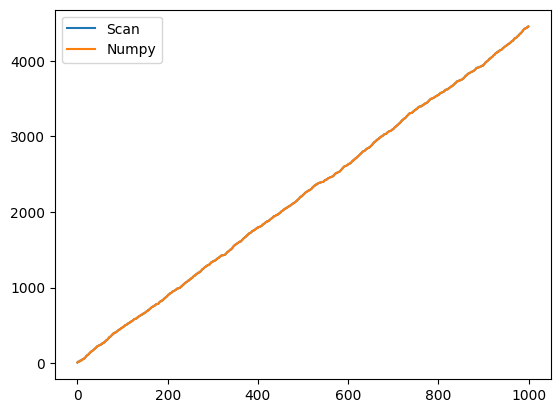

Error:  0


In [2]:
# Generate some random data to scan (ints between 0 and 10)
data = np.random.randint(0, 10, 1000, dtype=np.int32)

data_tf = tf.tensor(data)
scan_tf = scan_program(data_tf)

# do scan in numpy
scan_np = np.cumsum(data)

# Plot the original data and the scan
scan = scan_tf.numpy
plt.plot(scan, label="Scan")
plt.plot(scan_np, label="Numpy")
plt.legend()
plt.show()

#print error
print("Error: ", np.max(np.abs(scan - scan_np)))